In [1]:
import numpy as np
import os

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, accuracy_score, classification_report, roc_curve, auc, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import time
from sklearn.model_selection import RandomizedSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, Callback
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
DATA_PATH = os.path.join('MP_Data')                     # Path for exported data, numpy arrays
frames = 30                                             # Video frames

actions = np.array(['car', 'coffee', 'face', 'fall', 'friday', 'gold', 'goodbye', 'heart', 'hello', 'iloveyou', 'key', 'monday', 'music', 'phone', 'pretty', 'saturday', 'spring', 'summer', 'sunday', 'tea', 'thanks', 'thursday', 'tuesday', 'wednesday', 'winter'])
label_map = {label:num for num, label in enumerate(actions)}


In [3]:
sequences, labels = [], []
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    if not os.path.exists(action_path):
        print(f"Action path does not exist: {action_path}")
        continue
    
    sequences_list = os.listdir(action_path)
    if not sequences_list:
        print(f"No sequences found in path: {action_path}")
        continue
    
    for sequence in np.array(sequences_list).astype(int):
        window = []
        for frame_num in range(frames):
            frame_path = os.path.join(action_path, str(sequence), f"{frame_num}.npy")
            if not os.path.exists(frame_path):
                print(f"File does not exist: {frame_path}")
                continue
            
            res = np.load(frame_path)
            window.append(res)
        if window:
            sequences.append(window)
            labels.append(label_map[action])

print(f"Total sequences collected: {len(sequences)}")
print(f"Total labels collected: {len(labels)}")


Total sequences collected: 3750
Total labels collected: 3750


In [4]:
# Przygotowanie danych
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Podział na zbiór treningowy (70%) i zbiór tymczasowy (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Podział zbioru tymczasowego na zbiór walidacyjny (15%) i testowy (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Wyniki
print(f"Rozmiar zbioru treningowego: {len(X_train)}")
print(f"Rozmiar zbioru walidacyjnego: {len(X_val)}")
print(f"Rozmiar zbioru testowego: {len(X_test)}")

Rozmiar zbioru treningowego: 2625
Rozmiar zbioru walidacyjnego: 562
Rozmiar zbioru testowego: 563


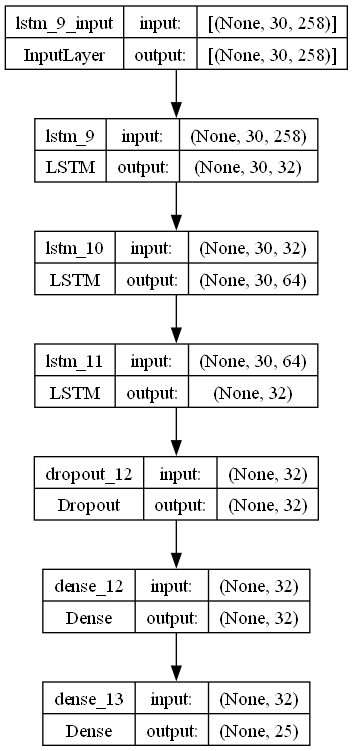

In [10]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/' 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

# Definicja modelu lstm
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30, 258)))
model_lstm.add(LSTM(64, return_sequences=True, activation='relu'))
model_lstm.add(LSTM(32, return_sequences=False, activation='relu'))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(actions.shape[0], activation='softmax'))

# Definicja modelu CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(32, 3, activation='relu', input_shape=(30, 258)))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Dropout(0.1))
model_cnn.add(Conv1D(64, 3, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Dropout(0.1))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(actions.shape[0], activation='softmax'))

# Generowanie diagramu architektury modelu
plot_model(model_lstm, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
# plot_model(model_cnn, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [10]:
# Inicjalizacja callbacku wczesnego stopu
early_stopping = EarlyStopping(
    monitor='val_loss',                     # Metryka do monitorowania 
    patience=10,                            # Liczba epok bez poprawy, po których trening zostanie zatrzymany
    verbose=1,                              # Poziom logowania
    restore_best_weights=True               # Przywrócenie najlepszych wag modelu
)

### grid LSTM

In [12]:
# Callback do logowania strat w każdej epoce
class LoggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch+1}: loss = {logs.get('loss')}, val_loss = {logs.get('val_loss')}")

# Funkcja do budowania modelu
def build_model(units=16, activation='relu', dropout_rate=0.1):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, activation=activation, input_shape=(30, 258)))
    model.add(LSTM(units * 2, return_sequences=True, activation=activation))
    model.add(LSTM(units, return_sequences=False, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units, activation=activation))
    model.add(Dense(actions.shape[0], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

# Wrapper KerasClassifier
model = KerasClassifier(build_fn=build_model, verbose=1)

# Definicja siatki hiperparametrów dla Grid Search (z dodanym dropout_rate)
param_grid = {
    'units': [16, 32, 64],
    'batch_size': [16, 32],
    'dropout_rate': [0.1, 0.2, 0.3]
}

# Funkcja do trenowania i ewaluacji modelu
def train_and_evaluate(units, batch_size, dropout_rate, epochs=50):
    kf = KFold(n_splits=2)
    fold_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Budowanie modelu
        model = build_model(units=units, dropout_rate=dropout_rate)

        # Trenowanie modelu
        history = model.fit(
            X_train_fold, y_train_fold, 
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=(X_val_fold, y_val_fold), 
            callbacks=[early_stopping, LoggingCallback()]
        )

        # Ewaluacja modelu
        val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
        fold_scores.append(val_accuracy)

    mean_score = np.mean(fold_scores)
    return mean_score

# Przechowywanie wyników
results = []

# Iteracja przez różne kombinacje hiperparametrów
for units in param_grid['units']:
    for batch_size in param_grid['batch_size']:
        for dropout_rate in param_grid['dropout_rate']:
            mean_score = train_and_evaluate(units, batch_size, dropout_rate)
            results.append({'units': units, 'batch_size': batch_size, 'dropout_rate': dropout_rate, 'mean_score': mean_score})

# Konwersja wyników do DataFrame
results_df = pd.DataFrame(results)

# Wyświetlanie wyników
for result in results:
    print(f"Units: {result['units']}, Batch Size: {result['batch_size']}, Dropout Rate: {result['dropout_rate']}, Mean Score: {result['mean_score']}")



C:\Users\kuba\AppData\Local\Temp\ipykernel_9768\975009032.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, verbose=1)


Epoch 1/50
82/82 [==============================] - 5s 27ms/step - loss: 3.1774 - categorical_accuracy: 0.0488 - val_loss: 3.0668 - val_categorical_accuracy: 0.0891
Epoch 2/50
82/82 [==============================] - 2s 22ms/step - loss: 2.9406 - categorical_accuracy: 0.0808 - val_loss: 2.8588 - val_categorical_accuracy: 0.0838
Epoch 3/50
82/82 [==============================] - 2s 20ms/step - loss: 2.7200 - categorical_accuracy: 0.0892 - val_loss: 2.6592 - val_categorical_accuracy: 0.0967
Epoch 4/50
82/82 [==============================] - 2s 20ms/step - loss: 2.5459 - categorical_accuracy: 0.1189 - val_loss: 2.4761 - val_categorical_accuracy: 0.1127
Epoch 5/50
82/82 [==============================] - 2s 20ms/step - loss: 2.3987 - categorical_accuracy: 0.1738 - val_loss: 2.2089 - val_categorical_accuracy: 0.1759
Epoch 6/50
82/82 [==============================] - 2s 20ms/step - loss: 2.4223 - categorical_accuracy: 0.1822 - val_loss: 2.6553 - val_categorical_accuracy: 0.1386
Epoch 7/50

Liczba jednostek: 16, Rozmiar partii: 16, Wskaźnik dropout: 0.1, Średni wynik: 0.4518357217311859
Liczba jednostek: 16, Rozmiar partii: 16, Wskaźnik dropout: 0.2, Średni wynik: 0.5615125894546509
Liczba jednostek: 16, Rozmiar partii: 16, Wskaźnik dropout: 0.3, Średni wynik: 0.5973531305789948
Liczba jednostek: 16, Rozmiar partii: 32, Wskaźnik dropout: 0.1, Średni wynik: 0.6156281530857086
Liczba jednostek: 16, Rozmiar partii: 32, Wskaźnik dropout: 0.2, Średni wynik: 0.5943046808242798
Liczba jednostek: 16, Rozmiar partii: 32, Wskaźnik dropout: 0.3, Średni wynik: 0.5561542809009552
Liczba jednostek: 32, Rozmiar partii: 16, Wskaźnik dropout: 0.1, Średni wynik: 0.7653466463088989
Liczba jednostek: 32, Rozmiar partii: 16, Wskaźnik dropout: 0.2, Średni wynik: 0.6499568223953247
Liczba jednostek: 32, Rozmiar partii: 16, Wskaźnik dropout: 0.3, Średni wynik: 0.3576764613389969
Liczba jednostek: 32, Rozmiar partii: 32, Wskaźnik dropout: 0.1, Średni wynik: 0.6917692720890045
Liczba jednostek: 32

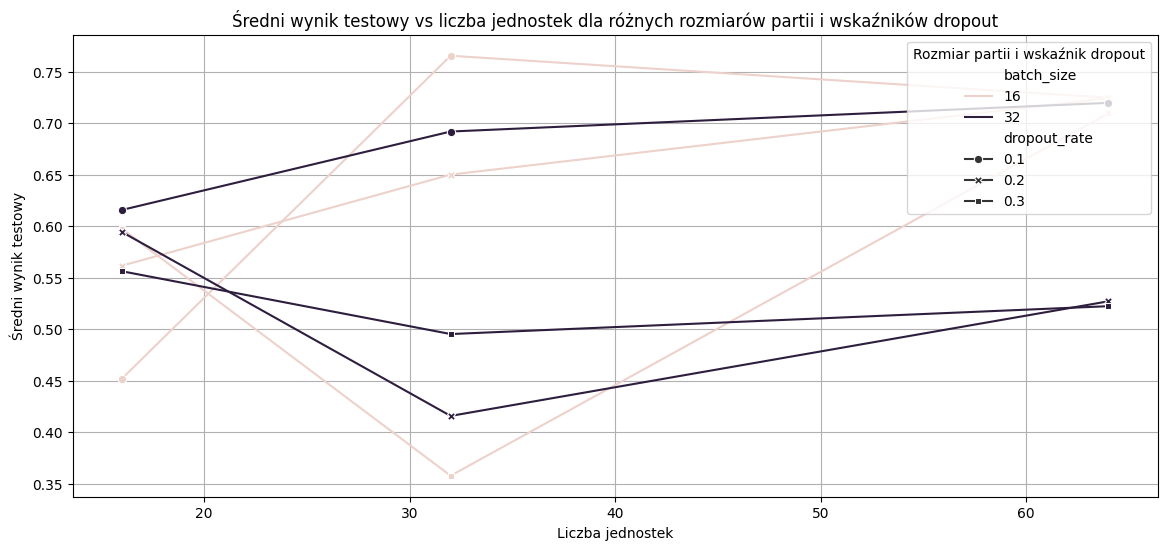

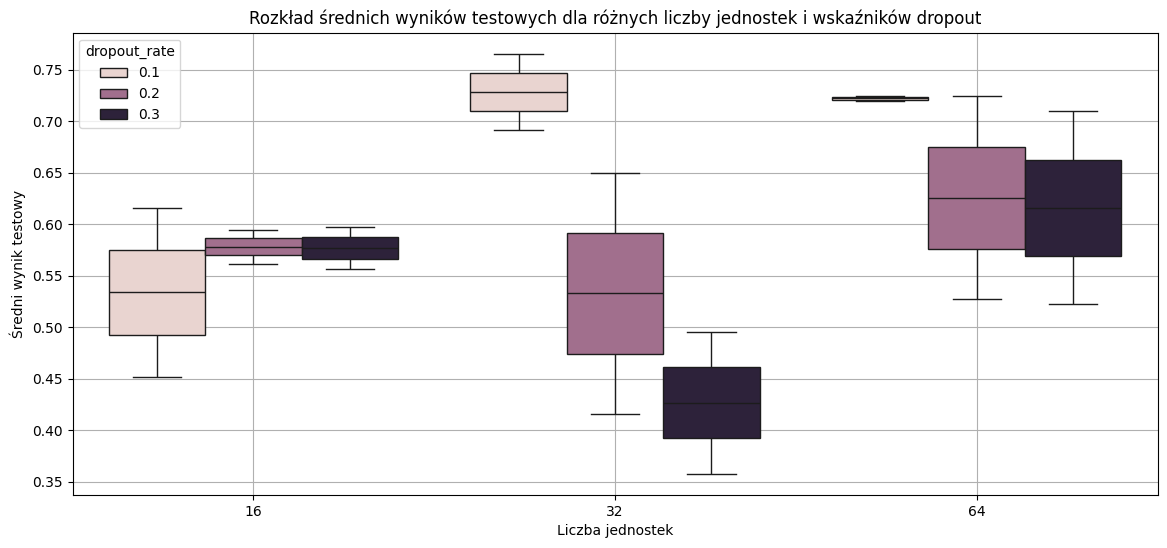


Tabela przestawna wyników (Średni wynik testowy):
batch_size          16                            32                    
dropout_rate       0.1       0.2       0.3       0.1       0.2       0.3
units                                                                   
16            0.451836  0.561513  0.597353  0.615628  0.594305  0.556154
32            0.765347  0.649957  0.357676  0.691769  0.415725  0.495192
64            0.724570  0.724209  0.709335  0.719605  0.526946  0.522235


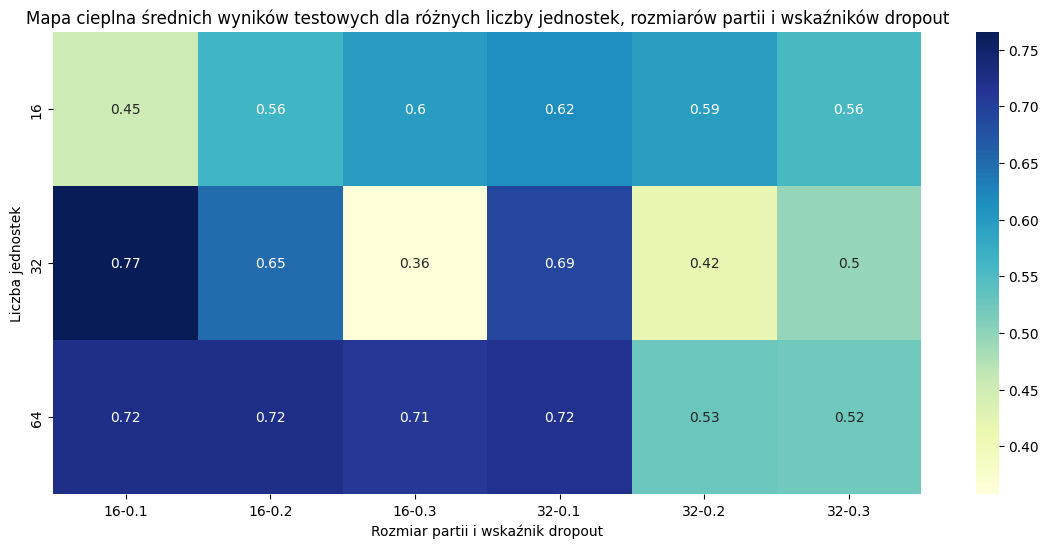

In [14]:
# Wyświetlanie wyników
for result in results:
    print(f"Liczba jednostek: {result['units']}, Rozmiar partii: {result['batch_size']}, Wskaźnik dropout: {result['dropout_rate']}, Średni wynik: {result['mean_score']}")

# Wizualizacja wyników
plt.figure(figsize=(14, 6))
sns.lineplot(x=results_df['units'], y=results_df['mean_score'], hue=results_df['batch_size'], style=results_df['dropout_rate'], markers=True, dashes=False)
plt.xlabel('Liczba jednostek')
plt.ylabel('Średni wynik testowy')
plt.title('Średni wynik testowy vs liczba jednostek dla różnych rozmiarów partii i wskaźników dropout')
plt.legend(title='Rozmiar partii i wskaźnik dropout', loc='upper right')
plt.grid(True)
plt.show()

# Wykres rozkładu wyników dla różnych wartości liczby jednostek (Boxplot)
plt.figure(figsize=(14, 6))
sns.boxplot(x='units', y='mean_score', hue='dropout_rate', data=results_df)
plt.xlabel('Liczba jednostek')
plt.ylabel('Średni wynik testowy')
plt.title('Rozkład średnich wyników testowych dla różnych liczby jednostek i wskaźników dropout')
plt.grid(True)
plt.show()

# Tabela przestawna wyników
results_table = results_df.pivot(index="units", columns=["batch_size", "dropout_rate"], values="mean_score")
print("\nTabela przestawna wyników (Średni wynik testowy):")
print(results_table)

# Wykres przestawny wyników
plt.figure(figsize=(14, 6))
sns.heatmap(results_table, annot=True, cmap="YlGnBu")
plt.xlabel('Rozmiar partii i wskaźnik dropout')
plt.ylabel('Liczba jednostek')
plt.title('Mapa cieplna średnich wyników testowych dla różnych liczby jednostek, rozmiarów partii i wskaźników dropout')
plt.show()


### CNN

In [21]:
import time
from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Callback do logowania strat w każdej epoce
class LoggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch+1}: loss = {logs.get('loss')}, val_loss = {logs.get('val_loss')}")

# Funkcja do budowania modelu CNN
def build_model(filters=32, activation='relu', dropout_rate=0.1):
    model = Sequential()
    model.add(Conv1D(filters, 3, activation=activation, input_shape=(30, 258)))
    model.add(MaxPooling1D(2))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(filters * 2, 3, activation=activation))
    model.add(MaxPooling1D(2))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(filters * 2, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(actions.shape[0], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

# Wrapper KerasClassifier
model = KerasClassifier(build_fn=build_model, verbose=1)

# Definicja siatki hiperparametrów dla Grid Search
param_grid = {
    'filters': [16, 32, 64],
    'batch_size': [16, 32],
    'dropout_rate': [0.1, 0.2, 0.3]
}

# Funkcja do trenowania i ewaluacji modelu
def train_and_evaluate(filters, batch_size, dropout_rate, epochs=50):
    kf = KFold(n_splits=2)
    fold_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Budowanie modelu
        model = build_model(filters=filters, dropout_rate=dropout_rate)

        # Trenowanie modelu
        history = model.fit(
            X_train_fold, y_train_fold, 
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=(X_val_fold, y_val_fold), 
            callbacks=[early_stopping, LoggingCallback()]
        )

        # Ewaluacja modelu
        val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
        fold_scores.append(val_accuracy)

    mean_score = np.mean(fold_scores)
    return mean_score

# Przechowywanie wyników
results = []

# Iteracja przez różne kombinacje hiperparametrów
for filters in param_grid['filters']:
    for batch_size in param_grid['batch_size']:
        for dropout_rate in param_grid['dropout_rate']:
            mean_score = train_and_evaluate(filters, batch_size, dropout_rate)
            results.append({'filters': filters, 'batch_size': batch_size, 'dropout_rate': dropout_rate, 'mean_score': mean_score})

# Konwersja wyników do DataFrame
results_df = pd.DataFrame(results)

# Wyświetlanie wyników
for result in results:
    print(f"Liczba filtrów: {result['filters']}, Rozmiar partii: {result['batch_size']}, Wskaźnik dropout: {result['dropout_rate']}, Średni wynik: {result['mean_score']}")


C:\Users\kuba\AppData\Local\Temp\ipykernel_9768\2247098176.py:35: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, verbose=1)


Epoch 1/50
82/82 [==============================] - 2s 10ms/step - loss: 3.1227 - categorical_accuracy: 0.0686 - val_loss: 2.8735 - val_categorical_accuracy: 0.1112
Epoch 2/50
82/82 [==============================] - 1s 6ms/step - loss: 2.7453 - categorical_accuracy: 0.0983 - val_loss: 2.5590 - val_categorical_accuracy: 0.2041
Epoch 3/50
82/82 [==============================] - 1s 7ms/step - loss: 2.4622 - categorical_accuracy: 0.1730 - val_loss: 2.1863 - val_categorical_accuracy: 0.2688
Epoch 4/50
82/82 [==============================] - 1s 6ms/step - loss: 2.0551 - categorical_accuracy: 0.2889 - val_loss: 1.8531 - val_categorical_accuracy: 0.3534
Epoch 5/50
82/82 [==============================] - 1s 7ms/step - loss: 1.8046 - categorical_accuracy: 0.3659 - val_loss: 1.6088 - val_categorical_accuracy: 0.4303
Epoch 6/50
82/82 [==============================] - 1s 6ms/step - loss: 1.5631 - categorical_accuracy: 0.4482 - val_loss: 1.3292 - val_categorical_accuracy: 0.5347
Epoch 7/50
82/8

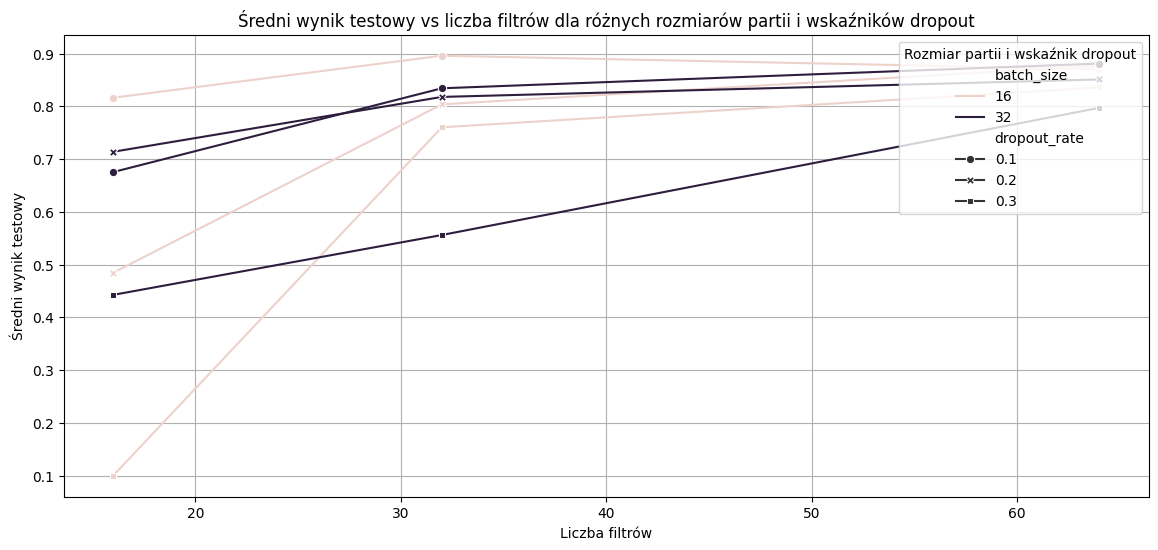

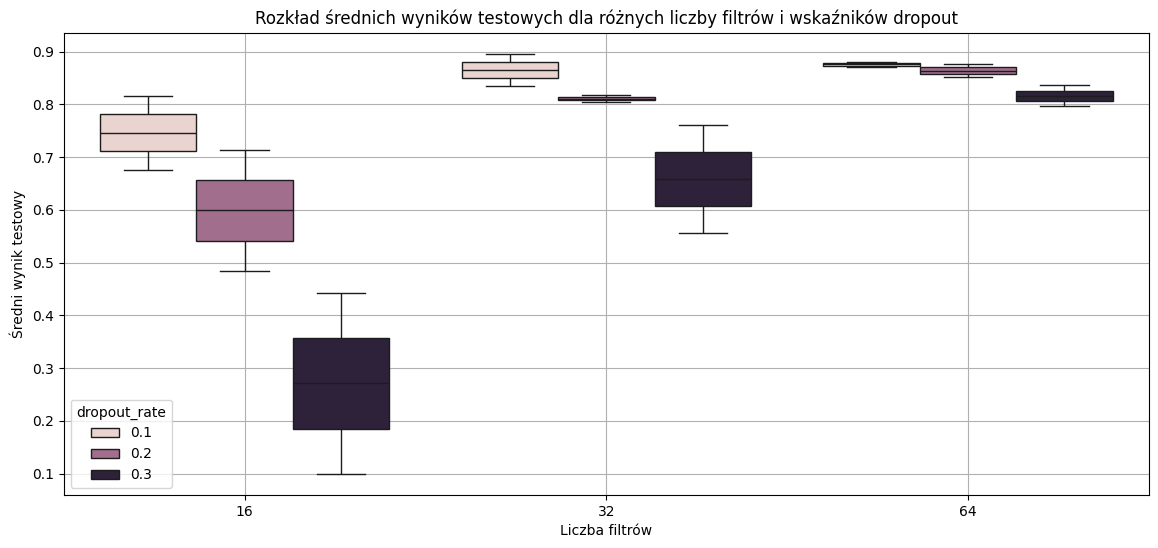


Tabela przestawna wyników (Średni wynik testowy):
batch_size          16                            32                    
dropout_rate       0.1       0.2       0.3       0.1       0.2       0.3
filters                                                                 
16            0.816381  0.484472  0.099788  0.675400  0.713875  0.442601
32            0.895999  0.803805  0.760365  0.834281  0.817900  0.556126
64            0.870464  0.877323  0.835801  0.881132  0.851046  0.797305


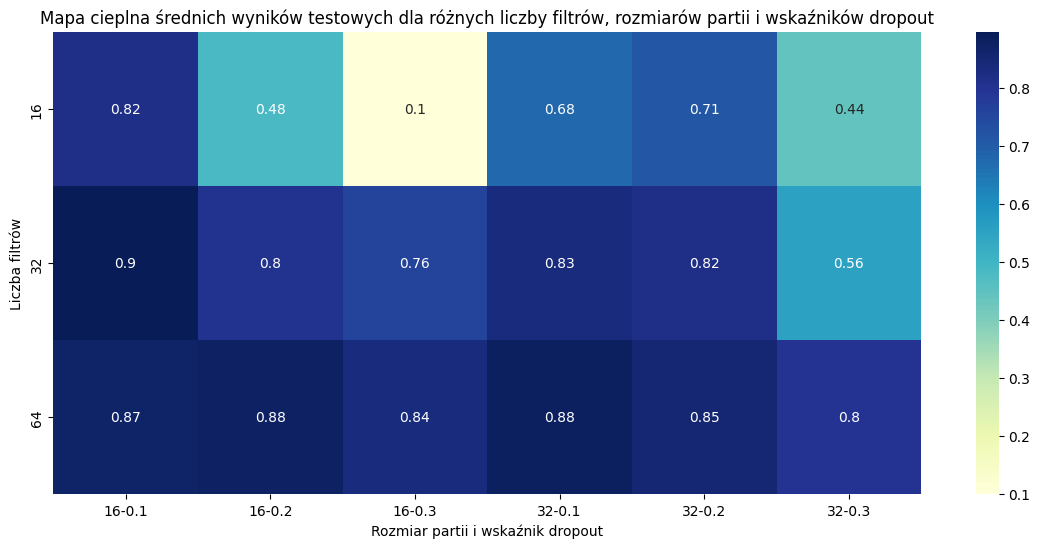

In [22]:
# Wizualizacja wyników
plt.figure(figsize=(14, 6))
sns.lineplot(x=results_df['filters'], y=results_df['mean_score'], hue=results_df['batch_size'], style=results_df['dropout_rate'], markers=True, dashes=False)
plt.xlabel('Liczba filtrów')
plt.ylabel('Średni wynik testowy')
plt.title('Średni wynik testowy vs liczba filtrów dla różnych rozmiarów partii i wskaźników dropout')
plt.legend(title='Rozmiar partii i wskaźnik dropout', loc='upper right')
plt.grid(True)
plt.show()

# Wykres rozkładu wyników dla różnych wartości liczby filtrów (Boxplot)
plt.figure(figsize=(14, 6))
sns.boxplot(x='filters', y='mean_score', hue='dropout_rate', data=results_df)
plt.xlabel('Liczba filtrów')
plt.ylabel('Średni wynik testowy')
plt.title('Rozkład średnich wyników testowych dla różnych liczby filtrów i wskaźników dropout')
plt.grid(True)
plt.show()

# Tabela przestawna wyników
results_table = results_df.pivot(index="filters", columns=["batch_size", "dropout_rate"], values="mean_score")
print("\nTabela przestawna wyników (Średni wynik testowy):")
print(results_table)

# Wykres przestawny wyników
plt.figure(figsize=(14, 6))
sns.heatmap(results_table, annot=True, cmap="YlGnBu")
plt.xlabel('Rozmiar partii i wskaźnik dropout')
plt.ylabel('Liczba filtrów')
plt.title('Mapa cieplna średnich wyników testowych dla różnych liczby filtrów, rozmiarów partii i wskaźników dropout')
plt.show()
